# State Tax Burden Analysis
## Author: Oliverius, Miranda

## Table of Contents

* [Overview](#overview)
* [Data Source](#source)
    - [List of Features](#features)
* [Data Preparation](#preparation)
    - [Preliminaries](#preliminaries)
    - [Data Cleaning](#cleaning)
    - [Outlier Removal](#outliers)
* [Exploratory Data Analysis](#analysis)
    - [Quantitative Variables](#quantitative)
    - [Categorical Variables](#categorical)
* [Conclusion](#conclusion)

## Overview <a class='anchor' id='overview'></a>

April 15th is the notorious "Tax Day," but the individual income tax filing deadline isn't the only tax game in town. There are corporate taxes, payroll taxes, sales & use taxes, property taxes, excise taxes, and many others. Taxpayers experience the burden of taxation throughout their day-to-day lives: W-2 employees watch their tax withholdings come out before the net check hits their bank account, consumers see sales tax added at the bottom of their receipts, and property owners make property tax payments.

While taxes may be a small nuisance for some and a severe financial burden for others, they are a necessity for funding a lot of public services and programs that benefit individuals, their friends & family, and the communities they live in. Government spending contributes to public safety, transportation, infrastructure, and education programs, among many others.

We often think of taxes in terms of legal incidence, described as "the legal obligation to remit tax payments to state and local governments" (Tax Foundation, 2022). In other words, "which individuals or companies must physically send tax payments to state and local treasuries" (Tax Foundation, 2022).

However, legal incidence is generally different from economic incidence. Economic incidence measures "the final distribution of the economic burden of taxes" (Tax Foundation, 2022). A good example of this difference is how corporate income taxes are commonly remitted by companies (legal incidence), but some portion of that tax is usually shifted to others through "higher prices for consumers, lower wages for workers, reduced returns to shareholders, or some combination of the three" (Tax Foundation, 2022).

In another shift of economic incidence, tax exporting is "when some share of the burden of a tax imposed in one state is borne by those who live elsewhere," such as "Property taxes on vacation homes; Purchases by tourists on vacation; or Severance taxes on resource extraction" (Tax Foundation, 2022).

This analysis seeks to explore the total state tax burden per capita in all fifty states, with the following questions:
1. Are there insights to be drawn by evaluating the in-state and out-of-state portions of total tax burden?
2. Does living in a particular area of the United States affect the total tax burden per capita?
3. Does the partisan lean of a state affect the total tax burden experienced by its citizens?
4. Does individual income per capita affect total tax burden?
5. Does living in a state without an individual income tax affect total tax burden?

## Data Source <a class='anchor' id='source'></a>

The tax data used in this analysis was obtained from The Tax Foundation, a nonpartisan tax policy nonprofit. They publish state tax data, including the data used here: "Facts & Figures 2024: How Does Your State Compare?". This data summarizes data from the U.S. Census Bureau and is intended to serve "as a one-stop state tax data resource that compares all 50 states on over 40 measures of tax rates, collections, burdens, and more." The most recent year of tax data published is for 2022, as 2023 tax returns are still being filed and processed at this time.

The tax burden information in the Facts & Figures data only includes total tax burden, so The Tax Foundation's "State and Local Tax Burdens, Calendar Year 2022" data is utilized to obtain the breakdown between in-state and out-of-state tax burdens. This data was only available as a PDF, which was exported to an Excel workbook. Due to the number of common errors associated with converting PDFs to Excel files, the following changes were made before converting to a CSV file:
1. Merged columns were unmerged.
2. The table and page headers were deleted.
3. Column headers were converted to snake case.
4. The effective tax rate and rank columns were deleted, as this analysis seeks to analyze tax burden in terms of dollars per capita.

_** Note: Both the original PDF of the tax burden table and the converted CSV file are included in this GitHub repository._

Chris Halpert's "census_regions" repository was utilized to identify the census region and division for each state. The data from the CSV file was compared to the US Census website for verification.

Lastly, FiveThirtyEight's "partisan-lean" GitHub repository was utilized to identify the partisan lean of each state. FiveThirtyEight's partisan lean metric is "the average margin difference between how a state or district votes and how the country votes overall. Positive numbers mean Democratic leans, while negative numbers mean Republican leans." The data used in this project took into account election results through 2021. (FiveThirtyEight, 2022).

### List of Features <a class='anchor' id='features'></a>

* __state__: Values denoting each of the fifty states in the United States of America
* __region__: West, Midwest, South, Midwest
* __division__: Pacific, Mountain, West North Central, East North Central, West South Central, East South Central, South Atlantic
* __partisan_lean__: The average margin difference between how a state or district votes and how the country votes overall. Positive numbers mean Democratic leans, while negative numbers mean Republican leans.
* __total_tax_burden__: Total economic state-local tax burden per capita
* __in_state_tax_burden__: The portion of total tax burden paid to a state of residence per capita
* __out_state_tax_burden__: The portion of total tax burden paid to other states per capita
* __ind_income_tax_collections__: Individual income taxes collected per capita
* __ind_income__: Total personal income divided by mid-year population

## Data Preparation <a class='anchor' id='preparation'></a>

### Preliminaries <a class='anchor' id='preliminaries'></a>

First, libraries are loaded for data manipulation and visualization. Next, data from Excel and CSV files are loaded before cleaning the data in preparation for analysis.

In [1]:
# load libraries
## *** DATA MANIPULATION ***
import numpy as np
import pandas as pd
import functools as ft
## *** DATA VISUALIZATION ***
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import data from Excel file
xlsx = r'datasets\Facts-Figures-2024-State-Tax-Data-Tax-Foundation.xlsx'

In [3]:
# load individual sheets - facts_and_figures per capita data
income_tax = pd.read_excel(xlsx, sheet_name='12', skiprows=3, header=1, 
                           names=['state', 'ind_income_tax_collections'], usecols='B:C')

income = pd.read_excel(xlsx, sheet_name='41', skiprows=3, header=1, 
                       names=['state', 'ind_income'], usecols='B:C')

In [4]:
# import data from csv files
region = pd.read_csv(r'datasets\us census bureau regions and divisions.csv', 
                     header=0, names=['state', 'region', 'division'])

partisan = pd.read_csv(r'datasets\fivethirtyeight_partisan_lean_STATES.csv', 
                       header=0, names=['state', 'partisan_lean'])

burden = pd.read_csv(r'datasets\table_2_salt_burdens_by_state_2022.csv', 
                     header=0, names=['state', 'total_tax_burden', 'in_state_tax_burden', 'out_state_tax_burden'])

### Data Cleaning <a class='anchor' id='cleaning'></a>

For all imported data, any empty rows are identified and removed.

In [5]:
# create list of DFs
df_list = [region, partisan, burden, income_tax, income]

In [6]:
# determine if any DFs contain empty rows
for df in df_list:
    print(df.isnull().all(axis=1).sum())

0
0
0
7
8


In [7]:
# remove all empty rows from each DF
for df in df_list:
    df.dropna(how='all', inplace=True)

All of the separate DataFrames will be merged into one DataFrame on the state field. In preparation for this merge, the unique state values for are evaluated and data manipulation techniques are employed to ensure the use of standard two-letter state abbreviations across all DataFrames.

In [8]:
# view unique state values for each DF
for df in df_list:
    print(df['state'].unique())

['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID'
 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC'
 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VA' 'VT' 'WA' 'WI' 'WV' 'WY']
['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']
[' Alabama ' ' Alaska ' ' Arizona ' ' Arkansas ' ' California '
 ' Colorado ' ' Connecticut ' ' Delaware ' ' District  of  Columbia '
 

These unique state values reveal that the following inconsistencies need to be addressed before merging DataFrames:
1. Some values include leading and trailing whitespace
2. Some values include double spaces in strings that contain multiple words
3. Some values include extraneous letters after the relevant state value, enclosed in parentheses
4. There are three general categories of state values- 1) Standard two-letter abbreviations without punctuation, 2) Full state names without punctuation, and 3) Partial abbreviations with various punctuation

In [9]:
# remove leading and trailing whitespace
## regex resource: https://www.trymito.io/excel-to-python/functions/text/TRIM
for df in df_list:
    df['state'] = df['state'].str.strip()

In [10]:
# replace multi-space whitespaces with single spaces
## regex resource: https://www.trymito.io/excel-to-python/functions/text/TRIM
for df in df_list:
    df['state'] = df['state'].str.replace(r'\s+', ' ', regex=True)

In [11]:
# create function to remove extraneous characters from state column
## regex resource: https://stackoverflow.com/questions/20894525/how-to-remove-parentheses-and-all-data-within-using-pandas-python
for df in df_list:
    df['state'] = df['state'].str.replace(r'\s*\([^()]*\)', '', regex=True).str.strip()

In [12]:
# create dictionary to convert state values to standard two-letter abbreviations
state_abbr = {## partial state abbreviations with punctuation
              'U.S.': 'US', 'Ala.': 'AL', 'Alaska': 'AK', 'Ariz.': 'AZ', 'Ark.': 'AR', 'Calif.': 'CA', 'Colo.': 'CO', 'Conn.': 'CT', 'Del.': 'DE', 
              'Fla.': 'FL', 'Ga.': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Ill.': 'IL', 'Ind.': 'IN', 'Iowa': 'IA', 'Kans.': 'KS', 'Ky.': 'KY', 
              'La.': 'LA', 'Maine': 'ME', 'Md.': 'MD', 'Mass.': 'MA', 'Mich.': 'MI', 'Minn.': 'MN', 'Miss.': 'MS', 'Mo.': 'MO', 'Mont.': 'MT', 
              'Nebr.': 'NE', 'Nev.': 'NV', 'N.H.': 'NH', 'N.J.': 'NJ', 'N.M.': 'NM', 'N.Y.': 'NY', 'N.C.': 'NC', 'N.D.': 'ND', 'Ohio': 'OH', 
              'Okla.': 'OK', 'Ore.': 'OR', 'Pa.': 'PA', 'R.I.': 'RI', 'S.C.': 'SC', 'S.D.': 'SD', 'Tenn.': 'TN', 'Tex.': 'TX', 'Utah': 'UT', 
              'Vt.': 'VT', 'Va.': 'VA', 'Wash.': 'WA', 'W.Va.': 'WV', 'Wis.': 'WI', 'Wyo.': 'WY', 'D.C.': 'DC',
              ## full state names, skipping any keys stated above
              'Alabama': 'AL', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 
              'Florida': 'FL', 'Georgia': 'GA', 'Illinois': 'IL', 'Indiana': 'IN', 'Kansas': 'KS', 'Kentucky': 'KY', 
              'Louisiana': 'LA', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 
              'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 
              'North Carolina': 'NC', 'North Dakota': 'ND', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 
              'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 
              'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY', 'District of Columbia': 'DC'}

In [13]:
# map dictionary of state abbreviations to DF
for df in df_list:
    df['state'] = df['state'].map(state_abbr).fillna(df['state'])

Now, the DataFrames are merged together, the state field is set as the index, and the info() method is called to ensure that the combined DataFrame is consistent with expectations.

In [14]:
# merge all DFs with per capita information
## note that this will remove US and DC values since some DFs don't have that info - OK since I'm only analyzing the 50 states
## merging resource: https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns
state_tax = ft.reduce(lambda left, right: pd.merge(left, right, on='state'), df_list)

In [15]:
# set state column as index
state_tax.set_index('state', drop=True, inplace=True)

In [16]:
# view variables, confirm that each variable has 50 non-null observations, and confirm data types
state_tax.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, AK to WY
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   region                      50 non-null     object 
 1   division                    50 non-null     object 
 2   partisan_lean               50 non-null     float64
 3   total_tax_burden            50 non-null     int64  
 4   in_state_tax_burden         50 non-null     int64  
 5   out_state_tax_burden        50 non-null     int64  
 6   ind_income_tax_collections  50 non-null     object 
 7   ind_income                  50 non-null     float64
dtypes: float64(2), int64(3), object(3)
memory usage: 3.5+ KB


The DataFrame includes eight columns in addition to the state abbreviations: 1) Region, 2) Division, 3) Partisan Lean, 4) Total Tax Burden, 5) In-State Tax Burden, 6) Out-of-State Tax Burden, 7) Individual Income Tax Collections, and 8) Individual Income. Each column contains 50 non-null observations, one for each state, so there are no missing values to remove or impute.

All columns have the anticipated data types, with the exception of the ind_income_tax_collections column. This column contains numeric data, but the summary shows an 'object' data type. To identify the issue, the unique values for this column are reviewed and updated.

In [17]:
# view unique values for object column that was expected to be numeric
state_tax['ind_income_tax_collections'].unique()

array([0, 1196.0006171450636, 1216.158750803057, 1017.755592541962,
       3748.18275392798, 1994.4276853074102, 2729.428462850625,
       2344.8403952715994, '$0', 1666.8061987997016, 2615.973285436924,
       1552.9446764846223, 1329.2708855804794, 1806.2432566598616,
       1715.88012185646, 1645.7084948739735, 1367.762677233642,
       977.6947079669741, 3489.6538142248155, 1981.26882559096,
       1860.5724831781004, 1283.4546271844579, 2642.4028888734624,
       1445.4743123189855, 863.3957845194228, 2116.4326658361742,
       1641.5058043450474, 605.2130803064681, 1641.7286571514219,
       109.68716452396363, 2224.091992208998, 615.4834836738415,
       3577.419319986823, 955.3359196304435, 1030.0406473601513,
       2779.00423440501, 1340.4912836828144, 1770.9374902959353,
       1286.5065579631605, 2003.940891046732, 2268.8104954602227,
       1959.4074962111088, 1524.382243677879, 1412.3889071037943],
      dtype=object)

The array of unique values shows that all values are numeric except for '$0'. To correct the data type, the dollar sign is removed and these instances are changed to floats.

In [18]:
# remove dollar signs
state_tax['ind_income_tax_collections'] = state_tax['ind_income_tax_collections'].apply(lambda x: x.replace('$', '')
                                                                              if isinstance(x, str) else x).astype(float)

In [19]:
# confirm that datatype is numeric
state_tax['ind_income_tax_collections'].dtype

dtype('float64')

Lastly, the head of the DataFrame is called to review column order and identify any final cleaning steps needed before the data can be explored and analyzed.

In [20]:
state_tax.head()

,region,division,partisan_lean,total_tax_burden,in_state_tax_burden,out_state_tax_burden,ind_income_tax_collections,ind_income
state,,,,,,,,
AK,West,Pacific,-14.611100,2943,1527,1416,0.000000,68658.0
AL,South,East South Central,-29.179740,4585,3578,1007,1196.000617,50747.0
AR,South,West South Central,-31.501760,5031,3598,1433,1216.158751,52421.0
AZ,West,Mountain,-7.171309,5156,3997,1159,1017.755593,58131.0
CA,West,Pacific,25.745270,10167,8711,1457,3748.182754,77088.0


In [21]:
# reorder columns
state_tax = state_tax[['region', 'division', 'partisan_lean', 'ind_income', 'ind_income_tax_collections', 
                       'in_state_tax_burden', 'out_state_tax_burden', 'total_tax_burden']]

In [22]:
# round to two decimal places
state_tax = state_tax.round(2)

### Outlier Removal <a class='anchor' id='outliers'></a>

Outliers are not removed for two reasons:
1. This analysis seeks to analyze all fifty states
2. This analysis seeks to analyze trends and patterns, including any insights available from potential outliers.

## Exploratory Data Analysis <a class='anchor' id='analysis'></a>

In [23]:
#### graphs will need resized, attribute order evaluated, titles, legends, tickmarks, etc. fixed
#### center plots
#### consider spacing b/w subplots (three scatterplots)

### Quantitative Variables <a class='anchor' id='quantitative'></a>

A scatterplot matrix, correlation matrix, and table of descriptive statistics are generated for our exploratory data analysis of the quantitative variables before looking more closely at the relationship amongst these variables.

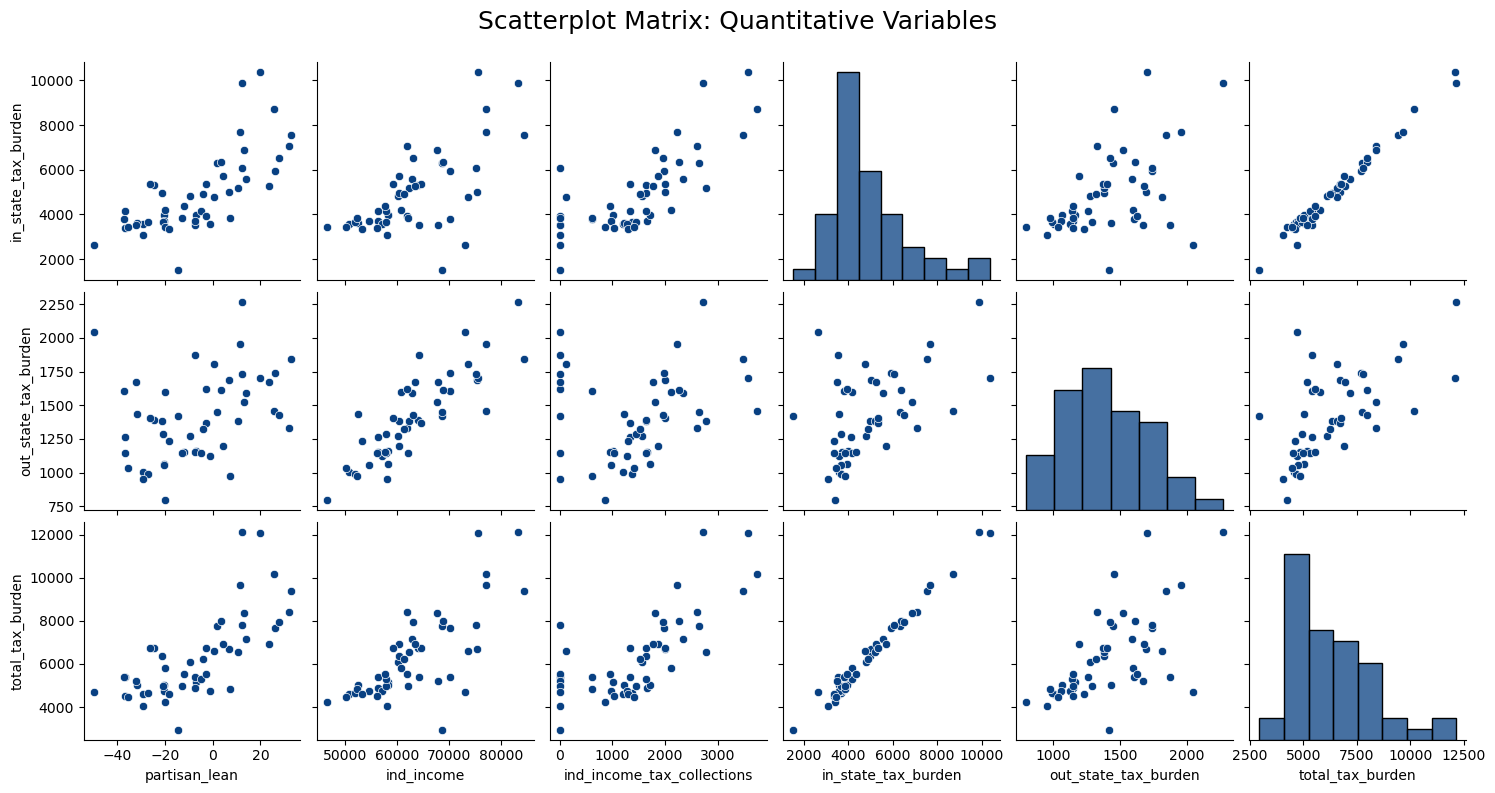

In [24]:
# plot scatterplot matrix with the three tax burden variables as dependent variables
## plot scatterplot matrix
ax = sns.pairplot(state_tax, y_vars=['in_state_tax_burden', 'out_state_tax_burden', 'total_tax_burden'], 
             plot_kws={'color': '#084082'}, diag_kws={'color': '#084082'})

## add labels
ax.fig.suptitle('Scatterplot Matrix: Quantitative Variables', y=1.05, fontsize=18)

## display plot
plt.show()

In [25]:
# save DataFrame of quantitative variables
state_tax_quantitative = state_tax.loc[:, ['partisan_lean', 'ind_income', 'ind_income_tax_collections',
                                           'in_state_tax_burden', 'out_state_tax_burden', 'total_tax_burden']]

In [26]:
# compute correlation matrix for quantitative variables
corr = state_tax_quantitative.corr()

In [27]:
# create mask for the upper-triangle
mask = np.triu(np.ones_like(corr))

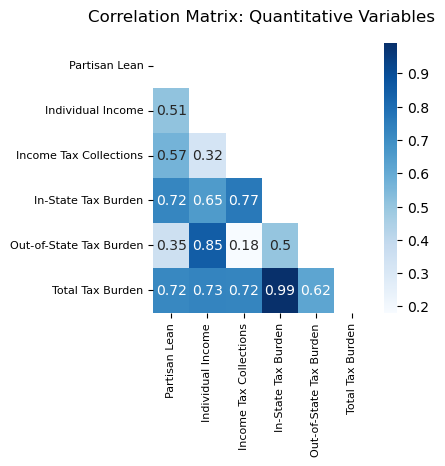

In [28]:
# plot diagonal correlation matrix
## set figure size
fig, ax = plt.subplots(figsize=(3.5, 3.5))

## plot correlation matrix
ax = sns.heatmap(corr, cmap='Blues', annot=True, mask=mask)

## add labels
ax.set_title('Correlation Matrix: Quantitative Variables', y=1.05, fontsize=12)
ax.set(xticklabels=(['Partisan Lean', 'Individual Income', 'Income Tax Collections', 
                       'In-State Tax Burden', 'Out-of-State Tax Burden', 'Total Tax Burden']))
ax.set(yticklabels=(['Partisan Lean', 'Individual Income', 'Income Tax Collections', 
                       'In-State Tax Burden', 'Out-of-State Tax Burden', 'Total Tax Burden']))

## adjust tick label size
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

## display plot
plt.show()

In [29]:
# compute basic descriptive statistics for quantitative variables
state_tax.describe()

,partisan_lean,ind_income,ind_income_tax_collections,in_state_tax_burden,out_state_tax_burden,total_tax_burden
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,-6.750800,63082.240000,1467.081800,4908.280000,1408.980000,6317.240000
std,20.798361,8676.674341,967.336035,1781.828997,314.627314,1959.128081
min,-49.870000,46382.000000,0.000000,1527.000000,798.000000,2943.000000
25%,-21.047500,57705.250000,960.927500,3669.250000,1149.500000,4884.750000
50%,-7.265000,61916.000000,1484.925000,4290.000000,1387.500000,5674.500000
75%,9.737500,68713.500000,1991.140000,5679.000000,1619.500000,7114.500000
max,32.680000,84439.000000,3748.180000,10380.000000,2268.000000,12151.000000


#### Tax Burden

The total tax burden is equal to in-state tax burden plus out-of-state tax burden, so it makes sense that both components have a positive correlation with the total burden. However, the scatterplot and correlation matrix reveal some additional insight: 

The scatterplot of in-state tax burden and total tax burden indicates a strong positive linear correlation compared to a weaker positive correlation between out-of-state tax burden and total tax burden. The computed correlations displayed on the diagonal correlation matrix support the visualizations, showing a 0.99 correlation between in-state and total tax burden. In contrast, the out-of-state and total tax burdens only have a correlation of 0.62. This indicates that the taxes paid to one's state of residence have a stronger linear relationship with total tax burden than those paid to another state.

Meanwhile, the histograms of the in-state, out-of-state, and total tax burdens indicate that in-state and total tax burden have the most similar distribution. These distributions are both right-skewed, while the out-of-state tax burden indicates a slightly more symmetric plot. This indicates that the mean in-state and total tax burdens are likely higher than the median, due to some high outliers. The out-of-state tax burden's symmetry implies that its values appear at regular frequencies and the mean and median are likely close to one another. This is confirmed by the descriptive statistics table:
1. The mean in-state tax burden is \\$4,908 per capita, compared to a median burden of \\$4,290 per capita.
2. The mean out-of-state tax burden is \\$1,409 per capita, compared to a median burden of \\$1,388 per capita.
3. The mean total tax burden is \\$6,317 per capita, compared to a median burden of \\$5,675 per capita.

#### Partisan Lean

Before discussing insights from the summary graphs and statistics, a scatterplot of partisan lean vs. total tax burden is generated to more closely examine the relationship between partisan lean and total tax burden.

The plot incorporates a red and blue color gradient, where red hues indicate states with a Republic partisan lean and blue hues indicate a Democratic partisan lean.

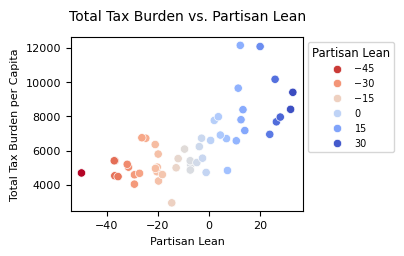

In [30]:
# plot scatterplot of total tax burden vs. partisan lean, with red and blue color gradient
## set figure size
fig, ax = plt.subplots(figsize=(3, 2.25))

## plot scatterplot
ax = sns.scatterplot(state_tax, x='partisan_lean', y='total_tax_burden', hue='partisan_lean', palette='coolwarm_r')

## add labels
ax.set_title('Total Tax Burden vs. Partisan Lean', y=1.05, fontsize=10)
ax.set_xlabel('Partisan Lean', fontsize=8)
ax.set_ylabel('Total Tax Burden per Capita', fontsize=8)

# adjust tick label size
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

## customize legend position and font size
plt.legend(title='Partisan Lean', loc='upper left', bbox_to_anchor=(1, 1), fontsize='x-small', title_fontsize='small')

## display plot
plt.show()

Partisan lean ranges from a minimum of -49.87 to a maximum of 32.68, where the minimum represents the most Republican state and the maximum represents the most Democratic state. The mean partisan lean is -6.75 and the median is -7.27, indicating that the central tendency is fairly close to a neutral partisan lean, with a slight inclination towards the Republic side of the scale. The interquartile range is -21.05 to 9.74, representing the partisan lean for the middle 50% of our data.

The scatterplots of partisan lean against in-state and total tax burden indicate strong correlations, compared to a weak or even non-existent correlation with the out-of-state tax burden. This is confirmed by the correlation matrix, which only has a correlation of 0.35 for out-of-state tax burden, compared with 0.72 for both in-state and total tax burden.

#### Individual Income

Before discussing insights from the summary graphs and statistics, scatterplots of individual income vs. the three tax burden variables are generated to more closely examine the relationship between individual income and total tax burden, as well as other insights from the summary graphs.

Given the insights drawn about partisan lean from the previous section, this plot utilizes the same red and blue color gradient to indicate partisan lean.

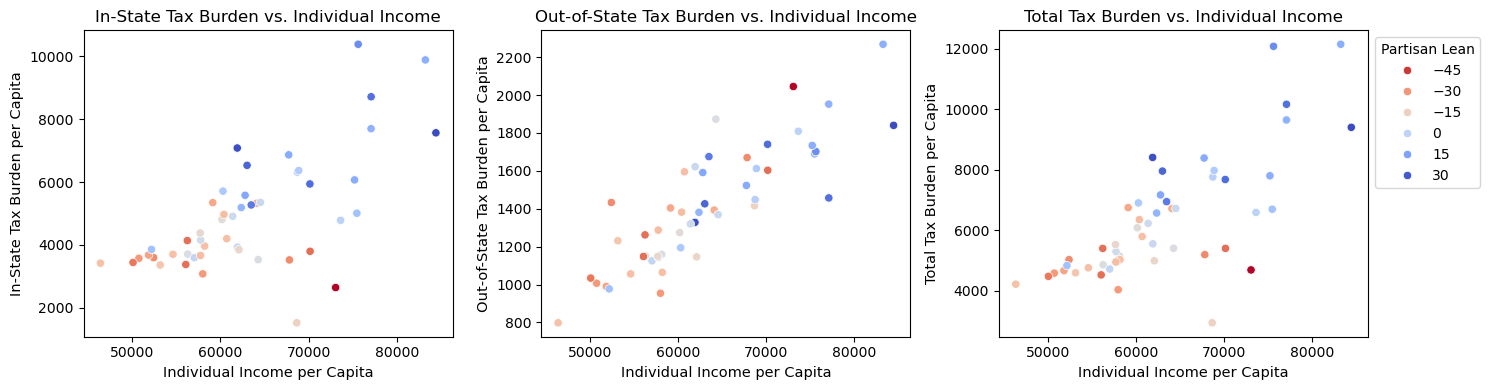

In [31]:
# plot scatterplots of tax burdens vs. individual income
## set figure size
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

## plot ind_income vs. in_state_tax_burden
sns.scatterplot(state_tax, x='ind_income', y='in_state_tax_burden', hue='partisan_lean', palette='coolwarm_r', ax=ax[0])

## plot ind_income vs. in_state_tax_burden
sns.scatterplot(state_tax, x='ind_income', y='out_state_tax_burden', hue='partisan_lean', palette='coolwarm_r', ax=ax[1])

## plot ind_income vs. in_state_tax_burden
sns.scatterplot(state_tax, x='ind_income', y='total_tax_burden', hue='partisan_lean', palette='coolwarm_r', ax=ax[2])

## add labels
ax[0].set_title('In-State Tax Burden vs. Individual Income', fontsize=12)
ax[0].set_xlabel('Individual Income per Capita', fontsize=10.5)
ax[0].set_ylabel('In-State Tax Burden per Capita', fontsize=10.5)
ax[1].set_title('Out-of-State Tax Burden vs. Individual Income', fontsize=12)
ax[1].set_xlabel('Individual Income per Capita', fontsize=10.5)
ax[1].set_ylabel('Out-of-State Tax Burden per Capita', fontsize=10.5)
ax[2].set_title('Total Tax Burden vs. Individual Income', fontsize=12)
ax[2].set_xlabel('Individual Income per Capita', fontsize=10.5)
ax[2].set_ylabel('Total Tax Burden per Capita', fontsize=10.5)

## remove extraneous legends (all three plots can use the same legend)
### legend removal resource: https://stackoverflow.com/questions/54781243/hide-legend-from-seaborn-pairplot
ax[0].legend([], [], frameon=False)
ax[1].legend([], [], frameon=False)

## customize legend position
ax[2].legend(title='Partisan Lean', loc='upper left', bbox_to_anchor=(1, 1))

## set tight layout
plt.tight_layout()

## display plot
plt.show()

Individual income per capita ranges from a minimum of \\$46,382 to a maximum of \\$84,439. The mean individual income per capita is \\$63,082 and the median is \\$61,916. The interquartile range is \\$57,705 to \\$68,714, which represents the range of individual income per capita for the middle 50% of our data.

The correlation between individual income per capita and total tax burden per capita is 0.73, indicating a strong positive correlation. This shows that as the individual income per capita increases, so does the total tax burden shouldered by a state's citizens.

The scatterplots and correlation values indicate that there are some other interesting insights to be garnered from our data:
1. Individual income per capita is more strongly correlated with out-of-state tax burden (0.85) than in-state tax burden (0.65) or total tax burden (0.73). This makes sense, given that states have more control over the in-state burden faced by their constituents (via the state tax policies they enact) than they do over the out-of-state burden.

   These statistics and plots indicate that regardless of a state's tax policies, people who live in states with higher individual income per capita will be faced with higher out-of-state tax burdens.

   One example of this is the darkest red point on all three scatterplots above- this state has a relatively high individual income per capita, but incurs a lower in-state and total tax burden. In contrast, that same red point has a high out-of-state tax burden.

2. When evaluating the color gradient applied to the three scatterplots of individual income and tax burdens, it appears that most lower income states are red states and that income per capita increases for blue states. However, the correlation between individual income and partisan lean is only 0.51.

   The scatterplot below takes a closer look at the relationship between partisan lean and individual income, which does confirm that many of the lower-income states have a Republic partisan lean, and many Democratic states have a high individual income per capita.

   However, the weak correlation is clear in this visualization, as a horizontal swatch of most income levels would return a wide variety of partisan leans. For example, individual income per capita between \\$60,000 and \\$65,000 includes several red and blue states.

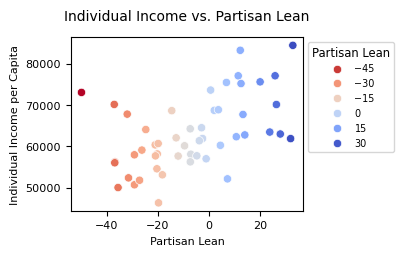

In [32]:
# plot scatterplot of individual income vs. partisan lean, with red and blue color gradient
## set figure size
fig, ax = plt.subplots(figsize=(3, 2.25))

## plot scatterplot
sns.scatterplot(state_tax, x='partisan_lean', y='ind_income', hue='partisan_lean', palette='coolwarm_r')

## add labels
ax.set_title('Individual Income vs. Partisan Lean', y=1.05, fontsize=10)
ax.set_xlabel('Partisan Lean', fontsize=8)
ax.set_ylabel('Individual Income per Capita', fontsize=8)

# adjust tick label size
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

## customize legend position and font size
plt.legend(title='Partisan Lean', loc='upper left', bbox_to_anchor=(1, 1), fontsize='x-small', title_fontsize='small')

## display plot
plt.show()

#### Individual Income Tax Collections

Before discussing insights from the summary graphs and statistics, a scatterplot of individual income tax collections vs. total tax burden is generated to more closely examine the relationship between individual income tax collections and total tax burden.

Given the insights drawn about partisan lean from the previous section, this plot utilizes the same red and blue color gradient to indicate partisan lean.

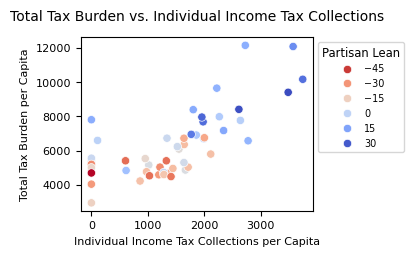

In [33]:
# plot scatterplot of total tax burden vs. individual income tax collections, with red and blue color gradient
## set figure size
fig, ax = plt.subplots(figsize=(3, 2.25))

## plot scatterplot
sns.scatterplot(state_tax, x='ind_income_tax_collections', y='total_tax_burden', hue='partisan_lean', palette='coolwarm_r')

## add labels
ax.set_title('Total Tax Burden vs. Individual Income Tax Collections', y=1.05, fontsize=10)
ax.set_xlabel('Individual Income Tax Collections per Capita', fontsize=8)
ax.set_ylabel('Total Tax Burden per Capita', fontsize=8)

# adjust tick label size
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

## customize legend position and font size
plt.legend(title='Partisan Lean', loc='upper left', bbox_to_anchor=(1, 1), fontsize='x-small', title_fontsize='small')

## display plot
plt.show()

Individual income tax collections per capita ranges from a minimum of \\$0 to a maximum of \\$3,748. The mean individual income tax collections per capita is \\$1,467 and the median is \\$1,485. The interquartile range is \\$961 to \\$1,991, which represents the range of individual income tax collections per capita for the middle 50% of our data.

The scatterplots of individual income tax collections and total tax burden indicate strong correlations, compared to a weak or even non-existent correlation with the out-of-state tax burden. This is confirmed by the correlation matrix, which shows correlations of 0.77 (in-state), 0.18 (out-of-state), and 0.72 (total). The high correlation between individual income tax collections and total state tax burden indicates that it is likely a good predictor of total tax burden.

Notably, as shown in the scatterplot above, there are two clusters of datapoints when plotting individual income tax collections against total tax burden: 1) states with no individual income tax collections, and 2) states that collect individual income tax.

After analyzing the data with these two clusters in mind, the following insights can be drawn:
1. Living in a state with no individual income tax does not inherently result in a lower total tax burden. The plot indicates varying levels of tax burdens for the no-income-tax states.
   
   This implies that most states that forgo an individual income tax potentially have increased other taxes, such as property or excise taxes, to adjust for the revenue they are not receiving from individual income taxes.

   Another component of total tax burden that would impact people in states without an individual income tax is their out-of-state tax burdens.
  
3. There are both Republican and Democratic states in both clusters and throughout the most dense section of the graph, indicating that there are varying income tax policies, regardless of political affiliation.

### Categorical Variables <a class='anchor' id='categorical'></a>

The categorical variables are plotted as bar graphs to get an idea of the number of states in each region and division before exploring the relationship between the categorical variables and total tax burden.

In [34]:
# create list of regions to have consistent order across plots, roughly going from west to east
region_order = ['West', 'Midwest', 'South', 'Northeast']

In [35]:
# create list of colors to correspond with each region
region_palette = {'West': '#858F99', 'Midwest': '#6AAED6', 'South': '#084082', 'Northeast': '#021326'}

In [36]:
# create list of divisions ordered so that divisions from each region are next to each other for consistency across plots
division_order = [# west region divisions
                  'Pacific', 'Mountain', 
                  # midwest region divisions
                  'West North Central', 'East North Central', 
                  # south region divisions
                  'West South Central', 'East South Central', 'South Atlantic', 
                      # northeast region divisions
                  'Middle Atlantic', 'New England']

#### Region

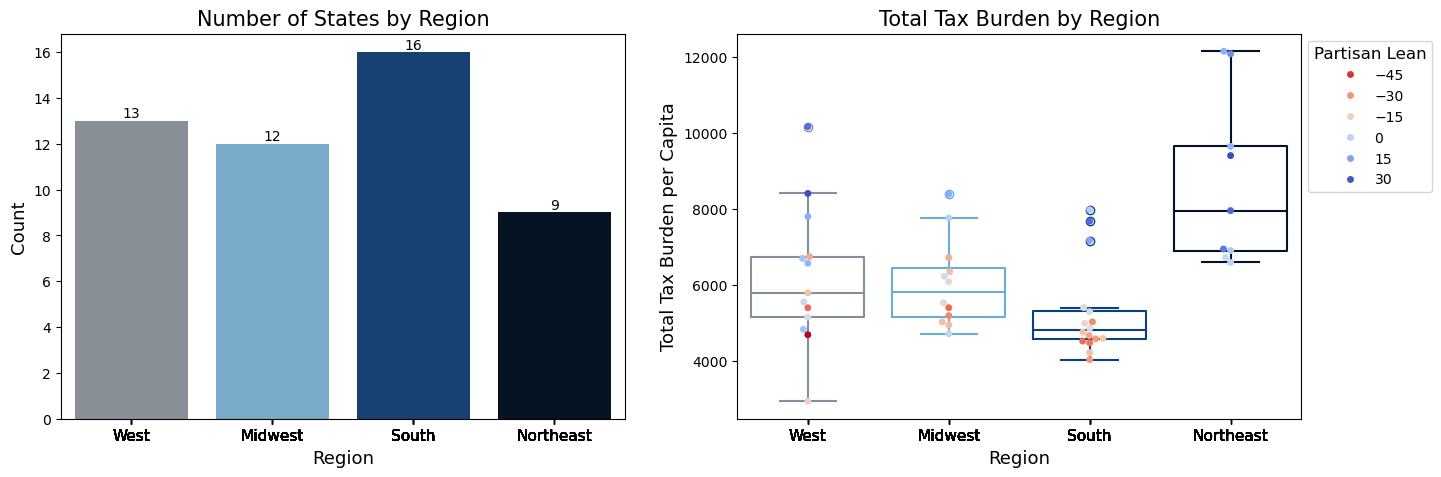

In [37]:
# plot countplot of regions next to boxplots w/ swarmplot overlays by region
## set figure size
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

## plot bar graph
sns.countplot(state_tax, x='region', hue='region', order=region_order, palette=region_palette, ax=ax[0])

## add counts above bars
### bar label resource: https://stackoverflow.com/questions/67112449/bar-labels-in-matplotlib-seaborn
for bars in ax[0].containers:
        ax[0].bar_label(bars)

## plot boxplots
sns.boxplot(state_tax, x='region', y='total_tax_burden', hue='region', order=region_order, palette=region_palette, fill=False, ax=ax[1])

## plot swarmplots
### swarm/box overlay resource: https://stackoverflow.com/questions/44615759/how-can-box-plot-be-overlaid-on-top-of-swarm-plot-in-seaborn
sns.swarmplot(state_tax, x='region', y='total_tax_burden', hue='partisan_lean', order=region_order, palette='coolwarm_r', ax=ax[1])

## add labels
ax[0].set_title('Number of States by Region', fontsize=15)
ax[0].set_xlabel('Region', fontsize=13)
ax[0].set_ylabel('Count', fontsize=13)
ax[1].set_title('Total Tax Burden by Region', fontsize=15)
ax[1].set_xlabel('Region', fontsize=13)
ax[1].set_ylabel('Total Tax Burden per Capita', fontsize=13)

## set tick marks
ax[0].set_xticks(state_tax['region'])
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=11)
ax[1].set_xticks(state_tax['region'])
ax[1].set_xticklabels(ax[0].get_xticklabels(), fontsize=11)

# customize legend position
## customize legend position and font size
plt.legend(title='Partisan Lean', loc='upper left', bbox_to_anchor=(1, 1), fontsize='medium', title_fontsize='large')

## adjust space between subplots
plt.subplots_adjust(wspace=0.2)

## display plot
plt.show()

##### Overview

The plot of the four regions shows that 50% of the states are in the West and Midwest. The other 50% are divided between the South and Northeast- the South region includes the most states (16) and the Northeast region includes the least number of states (9).

##### West

States in the West region have a wide range of tax values. Notably, the lower bound for this region represents the lowest tax burden across all four regions. Additionally, the state that is represented as a high outlier is still not as high as the upper bound for the Northeast region. A mix of partisan leans are indicated across the region.

##### Midwest

The Midwest region has a similar interquartile range to the West, though it's third quartile is not as high as that of the West. In addition, the lower and upper bounds encompass a much smaller range of tax burdens than the West region, and the state noted as an outlier for the Midwest has a similar tax burden to the upper bound of the West region. A mix of partisan leans are indicated across the region.

##### South

The boxplot for the South region is the most condensed plot out of the four regions. In addition, when comparing the interquartile ranges, the South has the lowest range of tax burdens. The lower and upper bounds are very close to the first and third quartiles, which is consistent with the swarm plot, which demonstrates a high density of states with similar tax burdens. This region has three outliers, all of which are blue states, but none of these outliers exceed the highest points demonstrated for any other region. A mix of partisan leans are indicated across the region.

##### Northeast

States in the Northeast region experience the highest tax burdens and only include states with a Democratic partisan lean. There are no outliers, but the upper bound and interquartile ranges are higher than the respective values for every other region. Additionally, the first quartile and lower bound are both higher than every other region's third quartile, but lower than the upper bounds for the West and Midwest.

#### Division

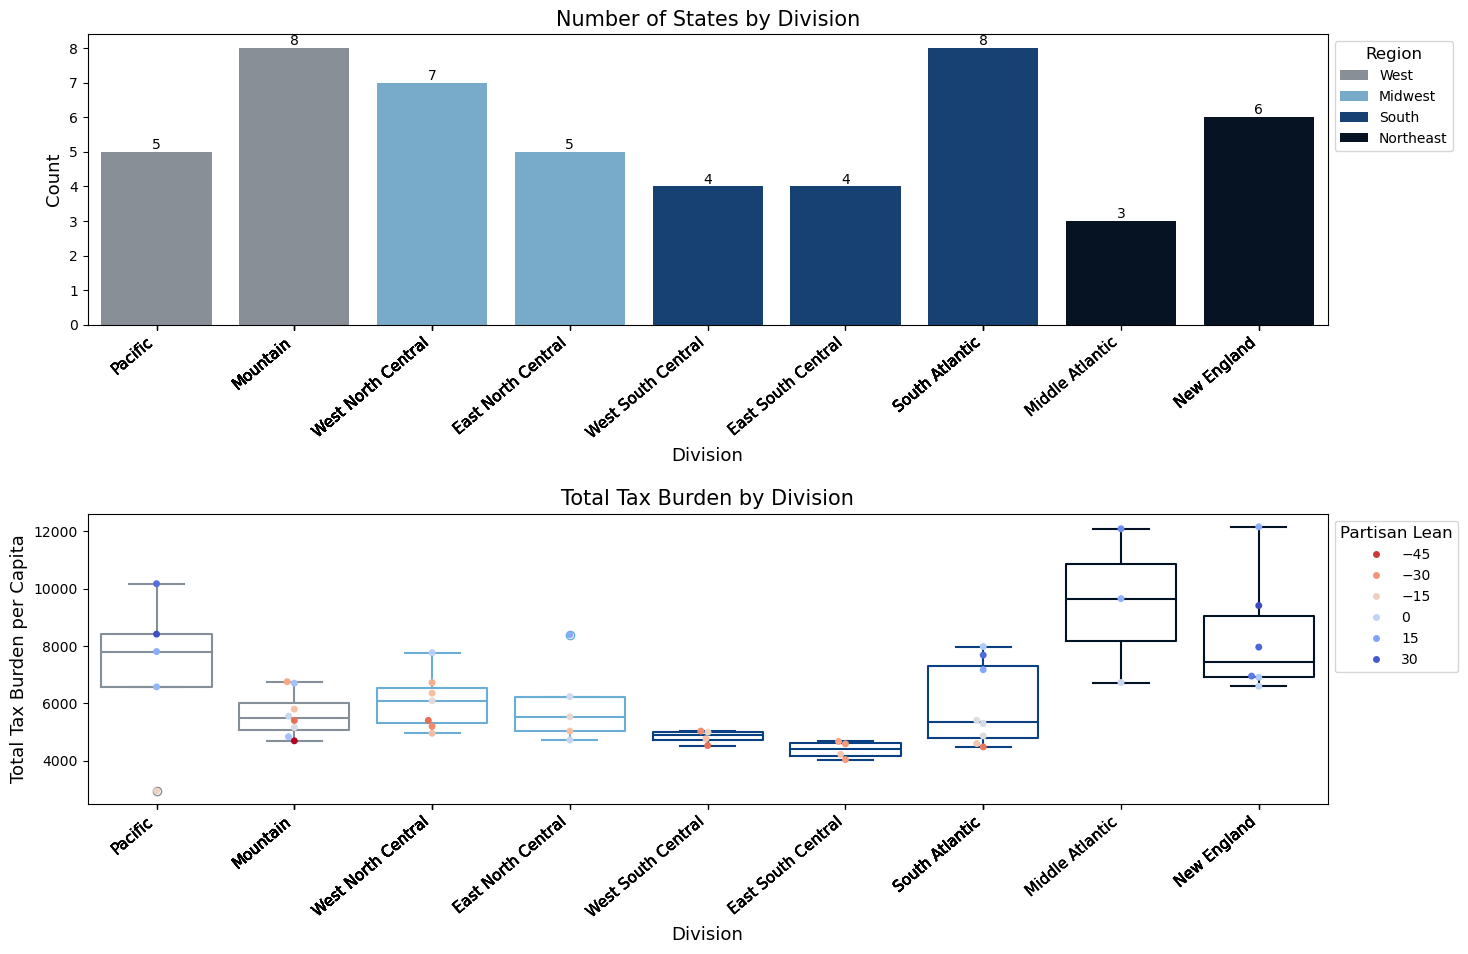

In [38]:
# plot bar graph of divisions above boxplots w/ swarmplot overlays by division
## set figure size
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

## plot bar graph

sns.countplot(state_tax, x='division', hue='region', order=division_order, palette=region_palette, ax=ax[0])

## add counts above bars
for bars in ax[0].containers:
    ax[0].bar_label(bars)

## plot boxplots
sns.boxplot(state_tax, x='division', y='total_tax_burden', hue='region', order=division_order, palette=region_palette, fill=False, ax=ax[1])

## plot swarmplots
sns.swarmplot(state_tax, x='division', y='total_tax_burden', hue='partisan_lean', order=division_order, palette='coolwarm_r', ax=ax[1])

## add labels
ax[0].set_title('Number of States by Division', fontsize=15)
ax[0].set_xlabel('Division', fontsize=13)
ax[0].set_ylabel('Count', fontsize=13)
ax[1].set_title('Total Tax Burden by Division', fontsize=15)
ax[1].set_xlabel('Division', fontsize=13)
ax[1].set_ylabel('Total Tax Burden per Capita', fontsize=13)

## set tick marks
### axis label resource: https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
ax[0].set_xticks(state_tax['division'])
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=11, ha='right', rotation=40)
ax[1].set_xticks(state_tax['division'])
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=11, ha='right', rotation=40)

## customize legend position
ax[0].legend(title='Region', loc='upper left', bbox_to_anchor=(1, 1))

## get handles and labels for each plot's legend
### legend order resource: https://www.geeksforgeeks.org/how-to-change-order-of-items-in-matplotlib-legend/
handles_bar, labels_bar = ax[0].get_legend_handles_labels()
handles_box, labels_box = ax[1].get_legend_handles_labels()

## reorder the legend lables for each plot
order_bar = [0, 3, 1, 2]
order_box = [4, 5, 6, 7, 8, 9]

## pass handle and labels lists along with order to each plot's legend
ax[0].legend([handles_bar[i] for i in order_bar], [labels_bar[i] for i in order_bar], title='Region', loc='upper left', 
             bbox_to_anchor=(1, 1), fontsize='medium', title_fontsize='large') 
ax[1].legend([handles_box[i] for i in order_box], [labels_box[i] for i in order_box], title='Partisan Lean', loc='upper left', 
             bbox_to_anchor=(1, 1), fontsize='medium', title_fontsize='large') 

## adjust space between subplots
plt.subplots_adjust(hspace=0.65)

## display plot
plt.show()

##### Overview

The plot of the nine divisions shows that each region contains two divisions, with the exception of the South region, which has three divisions. Each division contains three to eight states.

When evaluating all nine divisions together, the divisions closest to the East Coast and West Coast have tend to have higher tax burdens than the rest of the divisions.

##### West

The West includes the Pacific and Mountain divisions. The Mountain division encompasses almost all of the lowest tax burdens for the West region. However, the lowest tax burden for the entire country is in the Pacific division. That state was not considered an outlier when the entire West region was taken into account, but viewed within the context of only its division, it is considered an outlier. Lastly, the third highest tax burden in the country is included in the Pacific division, only exceeded by burdens in the Middle Atlantic and New England divisions.

##### Midwest

The Midwest includes the West North Central and East North Central divisions. These divisions have relatively similar interquartile ranges and lower bounds. Notably, the highest tax burden in the region is considered an outlier in the East North Central division and is higher than the upper bound of the West North Central division. However, when evaluated against the other three regions, the Midwest has the greatest similarity amongst divisions.

##### South

The South includes the West South Central, East South Central, and South Atlantic divisions. The West South Central and East South Central divisions have very similar boxplots, but the tax burdens are slightly higher in the West South Central division. 

The South Atlantic division is notable for many reasons. First, compared to each of the other two divisions (four states, each), this division has twice as many states (eight). Second, the South Atlantic division spans a much wider range of tax burdens and those burdens are higher than those faced in the West South Central or East South Central divisions.

##### Northeast

The Northeast includes the Middle Atlantic and New England divisions. These divisions have similar lower and upper bounds implying that the overall range of tax burdens is consistent across the region. Although the first and third quartiles are lower in the New England division, it should be noted that the Middle Atlantic division only consists of three states, all of which have similar tax burden counterparts amongst the six states in New England.

## Conclusion <a class='anchor' id='conclusion'></a>

Based on the analysis of The Tax Foundation data, the US Census regions and divisions, and the FiveThirtyEight partisan lean metric, the following key insights were obtained:
1. The in-state tax burden is significantly more correlated with total tax burden, when compared to its out-of-state counterpart.
2. The distributions of total tax burden by region and division indicate that geographical areas do impact the range of potential tax burdens that a resident might face.
3. The partisan lean is strongly correlated with in-state and total tax burden, indicating that political leanings affect tax policy and that policy does have an impact on the economic tax burden of constituents.
4. Individual income per capita is highly correlated with total tax burden, implying that people who live in states with higher income shoulder a higher tax burden. Moreover, individual income is more strongly correlated with out-of-state tax burden than in-state tax burden, implying that a state can control the in-state tax burden through policy but cannot avoid out-of-state tax burdens from scaling with per capita income.
5. Living in a state with no individual income tax does not provide free passage to paying little or no tax overall. The states that do not impose an individual income tax have a wide range of total tax burdens.

In the future, this analysis could be expanded upon by looking into the following:
1. Does total tax burden impact the quality, availability, and satisfaction with the services provided by government spending?
2. Does examining individual income and tax burdens for a sample of individual citizens across the country affect the conclusions drawn in this analysis? Would evaluating these topics at an individual level, rather than using aggregated per-capita information reveal any additional insights?

For individual constituents, economic tax burden is likely very impactful from a financial perspective. However, taxes will follow us wherever we go and non-tax items such as societal welfare, safe roads & bridges, climate preferences, proximity to loved ones, and a number of other personal factors impact the decision to live somewhere, or move somewhere else. As Benjamin Franklin said, "In this world, nothing can be said to be certain, except death and taxes." 

## References

Tax Foundation. (2024, April 3). *Facts & Figures 2024: How Does Your State Compare?* https://taxfoundation.org/data/all/state/2024-state-tax-data/

Tax Foundation. (2022, April 7). *State and Local Tax Burdens, Calendar Year 2022*. https://taxfoundation.org/data/all/state/tax-burden-by-state-2022/

Halpert, Chris. (2014, June 23). *census-regions*. GitHub. https://github.com/cphalpert/census-regions

FiveThirtyEight. (2022, September 9). *partisan-lean*. GitHub. https://github.com/fivethirtyeight/data/tree/master/partisan-lean